__Steps followed__

1. Import & News Cleanup 
2. LDA Topic Modelling for 3,5 & 10 Topics
3. LSA Topic Modelling for 10 Topics
4. Clustering using t-sne
5. Sentiment analysis on News Articles
6. Applied Classification models on #5
    a. Naive Bayes with Accuracy oh 76%
    b. XGBoost with accuracy og 86%
7. Named entity recognition
8. Targeted sentiment analysis on sentences were Organizations are mentioned
9. Targeted sentiment analysis on sentences were People are mentioned.



In [1]:
import warnings

warnings.simplefilter('ignore')


In [2]:
import time
import math
import re
from textblob import TextBlob
import pandas as pd

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis.gensim
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

# Reading the news file

In [3]:
directory = ''
news_articles = 'news_chicago_il.pkl'
path = directory+news_articles

In [4]:
news_df = pd.read_pickle(directory+news_articles)

In [5]:
news_df.head(5)

crawled_date language                                               text  \
0   2019-10-31  english  News October 31st, 2019 by Ric Hanson\nCEDAR R...   
1   2019-10-31  english  Chicago's teachers union voted to approve a te...   
2   2019-10-31  english  News KnowThis: Trump vs. Chicago & Relentless ...   
3   2019-10-31  english  You may have noticed that markets are taking a...   
4   2019-10-31  english  Anxious students feeling pinch amid Chicago te...   

                                               title  
0  Police say Illinois man targeted, killed in ea...  
1  Chicago teachers strike continues with tentati...  
2  KnowThis: Trump vs. Chicago & Relentless Fires...  
3  Jim Cramer Explains Why Markets Tanked on Weak...  
4  Anxious students feeling pinch amid Chicago te...

In [6]:
news_df.shape

(49122, 4)

# Clean-up the noise (eliminate articles irrelevant to the analysis)


In [7]:
# Filter non-English tweets
news_eng = news_df[news_df['language']=='english'].reset_index(drop=True)

In [8]:
from nltk.corpus import stopwords

In [9]:
words=[]
def stopwords(text):
    words=[w for w in text if w not in stopwords.words('english')]
    return words

In [10]:
import pandas as pd
from textblob import TextBlob
import numpy as np
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/srinivasbs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
news_eng['text'] = news_eng['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))


In [12]:
news_eng['text']=pd.DataFrame(news_eng['text'])

In [13]:
news_eng = pd.DataFrame(news_eng['text'].apply(str.lower))

In [14]:
news_eng=pd.DataFrame(news_eng[news_eng['text'].str.contains('population', na = False)])

In [15]:
news_eng.head(10)
news_eng.shape

(1128, 1)

In [16]:
# Remove special characters to avoid problems with analysis
news_eng['text_clean'] = news_eng['text'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))

In [17]:
pd.set_option('display.max_colwidth', 100)
news_eng[['text', 'text_clean']].head(5)

text  \
2    news knowthis: trump vs. chicago & relentless fires rage cali "we've seen fires tragedies people...   
44   reprints print century 21 pride realty this new house holland harbor drive lighthouse pointe dev...   
89   why pressure property taxes growing illinois amid pension burden the cost public safety pensions...   
119  reports: underrepresented students illinois institutions impacted budget cuts october 30, 2019 |...   
197  download wirepoints’ accompanying handout: “chicago’s financial crisis” today, talk city’s 2020 ...   

                                                                                              text_clean  
2    news knowthis: trump vs. chicago  relentless fires rage cali weve seen fires tragedies people be...  
44   reprints print century 21 pride realty this new house holland harbor drive lighthouse pointe dev...  
89   why pressure property taxes growing illinois amid pension burden the cost public safety pensions...  
119  reports: underrepresented students illinois institutions impacted budget cuts october 30, 2019  ...  
197  download wirepoints accompanying handout: chicagos financial crisis today, talk citys 2020 budge...

In [18]:
news_classification=pd.DataFrame(news_eng['text_clean'])

In [19]:
news_classification.head(10)

text_clean
2    news knowthis: trump vs. chicago  relentless fires rage cali weve seen fires tragedies people be...
44   reprints print century 21 pride realty this new house holland harbor drive lighthouse pointe dev...
89   why pressure property taxes growing illinois amid pension burden the cost public safety pensions...
119  reports: underrepresented students illinois institutions impacted budget cuts october 30, 2019  ...
197  download wirepoints accompanying handout: chicagos financial crisis today, talk citys 2020 budge...
204  people are leaving these major u.s. cities in droves, and we can relate to the reasons why updat...
549  teachers chicago, home nations thirdlargest school system, reached deal city thursday set return...
601  from wikipedia. village avon township, lake county, illinois. 1.88 square miles, 2010 population...
652  its time year ghouls goblins, mummies monsters force. but unlike many halloween creatures, bats ...
686  getty images president donald trump took swipe chicago visiting monday, saying city  longtime ta...

In [20]:
news_classification.shape

(1128, 1)

In [21]:
news_eng.shape

(1128, 2)

# Detect major topics

In [23]:
bloblist = []
del bloblist[:]

for i  in range(0,len(news_eng)):
    bloblist.append(TextBlob(news_eng['text_clean'].iloc[i]))
    
len(bloblist) 

1128

In [24]:
# http://stevenloria.com/finding-important-words-in-a-document-using-tf-idf/

def tf(word, blob):
    return blob.words.count(word) / len(blob.words)
# tf(word, blob) computes "term frequency" which is the number of times a word appears in a document blob, 
# normalized by dividing by the total number of words in blob. We use TextBlob for breaking up the text into words 
# and getting the word counts.


def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)
# n_containing(word, bloblist) returns the number of documents containing word. 
# A generator expression is passed to the sum() function.


def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))
# idf(word, bloblist) computes "inverse document frequency" which measures how common a word is 
# among all documents in bloblist. The more common a word is, the lower its idf. 
# We take the ratio of the total number of documents to the number of documents containing word, 
# then take the log of that. Add 1 to the divisor to prevent division by zero


def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)
# tfidf(word, blob, bloblist) computes the TF-IDF score. It is simply the product of tf and idf.

In [25]:
for i, blob in enumerate(bloblist):
# Print top 5 values
    if i == 5:
        break
    print("Top words in news article {}".format(i + 1))
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:10]:
        print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))

Top words in news article 1
	Word: knowthis, TF-IDF: 0.03915
	Word: kincade, TF-IDF: 0.03262
	Word: trump, TF-IDF: 0.02994
	Word: wildfires, TF-IDF: 0.02905
	Word: lyft, TF-IDF: 0.0279
	Word: fire, TF-IDF: 0.02343
	Word: isis, TF-IDF: 0.0226
	Word: rides, TF-IDF: 0.02232
	Word: forces, TF-IDF: 0.02221
	Word: raid, TF-IDF: 0.02094
Top words in news article 2
	Word: sales, TF-IDF: 0.11127
	Word: homes, TF-IDF: 0.08251
	Word: builders, TF-IDF: 0.07739
	Word: sold, TF-IDF: 0.06959
	Word: doersching, TF-IDF: 0.06241
	Word: thirdquarter, TF-IDF: 0.05842
	Word: tracy, TF-IDF: 0.05559
	Word: slowly, TF-IDF: 0.03753
	Word: pace, TF-IDF: 0.03641
	Word: lighthouse, TF-IDF: 0.03121
Top words in news article 3
	Word: pension, TF-IDF: 0.06068
	Word: pensions, TF-IDF: 0.0281
	Word: percent, TF-IDF: 0.0217
	Word: revenue, TF-IDF: 0.01864
	Word: funds, TF-IDF: 0.01773
	Word: property, TF-IDF: 0.01766
	Word: kass, TF-IDF: 0.01712
	Word: tax, TF-IDF: 0.0164
	Word: retirement, TF-IDF: 0.01577
	Word: ardis

### Applying LDA to news articles

In [26]:
news_list = news_eng['text_clean'].tolist()
news_list[:1]

['news knowthis: trump vs. chicago  relentless fires rage cali weve seen fires tragedies people believed could stay. do that. the thing cannot replace family. versha sharma published 10282019 11:00pm associated press relentless wildfires rage across california with no sign of stopping there two major raging wildfires threatening northern southern california, prompting gov. gavin newsom declare state emergency. the getty fire, started overnight los angeles, joins kincade fire started sonoma county last wednesday. last night, kincade fire still burning control fifth day, dropping 10 containment 5 due hurricaneforce winds dry conditions allowed spread made difficult control. several smaller fires also burning throughout state,  extremely critical fire weather conditions  remain. at around 2 a.m. monday, fire erupted near las famed getty museum. police told thousands people evacuate, including arnold schwarzenegger, lebron james, la mayor eric garcettis parents. about 25,000 live la evacua

In [27]:
doc_complete = []
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]     

In [28]:
news_clean = [clean(doc).split() for doc in news_list]

In [29]:
len(news_clean)

1128

In [30]:
print(*news_clean[:1], sep='\n\n')

['news', 'knowthis', 'trump', 'v', 'chicago', 'relentless', 'fire', 'rage', 'cali', 'weve', 'seen', 'fire', 'tragedy', 'people', 'believed', 'could', 'stay', 'that', 'thing', 'cannot', 'replace', 'family', 'versha', 'sharma', 'published', '10282019', '1100pm', 'associated', 'press', 'relentless', 'wildfire', 'rage', 'across', 'california', 'sign', 'stopping', 'two', 'major', 'raging', 'wildfire', 'threatening', 'northern', 'southern', 'california', 'prompting', 'gov', 'gavin', 'newsom', 'declare', 'state', 'emergency', 'getty', 'fire', 'started', 'overnight', 'los', 'angeles', 'join', 'kincade', 'fire', 'started', 'sonoma', 'county', 'last', 'wednesday', 'last', 'night', 'kincade', 'fire', 'still', 'burning', 'control', 'fifth', 'day', 'dropping', '10', 'containment', '5', 'due', 'hurricaneforce', 'wind', 'dry', 'condition', 'allowed', 'spread', 'made', 'difficult', 'control', 'several', 'smaller', 'fire', 'also', 'burning', 'throughout', 'state', 'extremely', 'critical', 'fire', 'weat

In [31]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 

dictionary = corpora.Dictionary(news_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.

%time doc_term_matrix = [dictionary.doc2bow(doc) for doc in news_clean]

CPU times: user 338 ms, sys: 8.56 ms, total: 347 ms
Wall time: 348 ms


#### 3 topic model

In [32]:
numtopics = 3

%time ldamodel = LdaMulticore(doc_term_matrix, num_topics=numtopics, id2word = dictionary, passes=50)

CPU times: user 9min 45s, sys: 10.9 s, total: 9min 56s
Wall time: 2min 17s


In [33]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=3), sep='\n')

(0, '0.006*"chicago" + 0.006*"illinois" + 0.005*"people"')
(1, '0.015*"school" + 0.015*"chicago" + 0.013*"said"')
(2, '0.020*"uf" + 0.015*"setigerum" + 0.015*"tu"')


In [34]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=5), sep='\n\n')

(0, '0.006*"chicago" + 0.006*"illinois" + 0.005*"people" + 0.005*"year" + 0.004*"u"')

(1, '0.015*"school" + 0.015*"chicago" + 0.013*"said" + 0.012*"teacher" + 0.010*"city"')

(2, '0.020*"uf" + 0.015*"setigerum" + 0.015*"tu" + 0.012*"plant" + 0.011*"somniferum"')


In [35]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=7), sep='\n\n')

(0, '0.006*"chicago" + 0.006*"illinois" + 0.005*"people" + 0.005*"year" + 0.004*"u" + 0.004*"health" + 0.004*"state"')

(1, '0.015*"school" + 0.015*"chicago" + 0.013*"said" + 0.012*"teacher" + 0.010*"city" + 0.009*"student" + 0.007*"state"')

(2, '0.020*"uf" + 0.015*"setigerum" + 0.015*"tu" + 0.012*"plant" + 0.011*"somniferum" + 0.011*"may" + 0.009*"hybrid"')


In [36]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=10), sep='\n\n')

(0, '0.006*"chicago" + 0.006*"illinois" + 0.005*"people" + 0.005*"year" + 0.004*"u" + 0.004*"health" + 0.004*"state" + 0.003*"community" + 0.003*"new" + 0.003*"one"')

(1, '0.015*"school" + 0.015*"chicago" + 0.013*"said" + 0.012*"teacher" + 0.010*"city" + 0.009*"student" + 0.007*"state" + 0.007*"illinois" + 0.006*"strike" + 0.006*"year"')

(2, '0.020*"uf" + 0.015*"setigerum" + 0.015*"tu" + 0.012*"plant" + 0.011*"somniferum" + 0.011*"may" + 0.009*"hybrid" + 0.007*"bracteatum" + 0.007*"coold" + 0.006*"orientale"')


In [37]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

#### 5 topic model

In [38]:
numtopics = 5

%time ldamodel = LdaMulticore(doc_term_matrix, num_topics=numtopics, id2word = dictionary, passes=50)

CPU times: user 9min 7s, sys: 1min 21s, total: 10min 29s
Wall time: 2min 28s


In [39]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=3), sep='\n\n')

(0, '0.020*"uf" + 0.016*"setigerum" + 0.015*"tu"')

(1, '0.013*"chicago" + 0.012*"said" + 0.011*"school"')

(2, '0.008*"health" + 0.006*"chicago" + 0.006*"job"')

(3, '0.011*"illinois" + 0.008*"2019" + 0.007*"view"')

(4, '0.014*"chicago" + 0.012*"school" + 0.011*"said"')


In [40]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=5), sep='\n\n')

(0, '0.020*"uf" + 0.016*"setigerum" + 0.015*"tu" + 0.012*"plant" + 0.012*"somniferum"')

(1, '0.013*"chicago" + 0.012*"said" + 0.011*"school" + 0.009*"teacher" + 0.009*"education"')

(2, '0.008*"health" + 0.006*"chicago" + 0.006*"job" + 0.005*"program" + 0.005*"community"')

(3, '0.011*"illinois" + 0.008*"2019" + 0.007*"view" + 0.006*"new" + 0.005*"university"')

(4, '0.014*"chicago" + 0.012*"school" + 0.011*"said" + 0.010*"city" + 0.009*"teacher"')


In [41]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=7), sep='\n\n')

(0, '0.020*"uf" + 0.016*"setigerum" + 0.015*"tu" + 0.012*"plant" + 0.012*"somniferum" + 0.012*"may" + 0.009*"hybrid"')

(1, '0.013*"chicago" + 0.012*"said" + 0.011*"school" + 0.009*"teacher" + 0.009*"education" + 0.008*"special" + 0.008*"people"')

(2, '0.008*"health" + 0.006*"chicago" + 0.006*"job" + 0.005*"program" + 0.005*"community" + 0.005*"medical" + 0.005*"care"')

(3, '0.011*"illinois" + 0.008*"2019" + 0.007*"view" + 0.006*"new" + 0.005*"university" + 0.004*"obama" + 0.004*"chicago"')

(4, '0.014*"chicago" + 0.012*"school" + 0.011*"said" + 0.010*"city" + 0.009*"teacher" + 0.008*"illinois" + 0.008*"state"')


In [42]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=10), sep='\n\n')

(0, '0.020*"uf" + 0.016*"setigerum" + 0.015*"tu" + 0.012*"plant" + 0.012*"somniferum" + 0.012*"may" + 0.009*"hybrid" + 0.007*"bracteatum" + 0.007*"coold" + 0.006*"orientale"')

(1, '0.013*"chicago" + 0.012*"said" + 0.011*"school" + 0.009*"teacher" + 0.009*"education" + 0.008*"special" + 0.008*"people" + 0.007*"student" + 0.006*"year" + 0.006*"state"')

(2, '0.008*"health" + 0.006*"chicago" + 0.006*"job" + 0.005*"program" + 0.005*"community" + 0.005*"medical" + 0.005*"care" + 0.005*"experience" + 0.005*"work" + 0.004*"business"')

(3, '0.011*"illinois" + 0.008*"2019" + 0.007*"view" + 0.006*"new" + 0.005*"university" + 0.004*"obama" + 0.004*"chicago" + 0.004*"center" + 0.003*"study" + 0.003*"u"')

(4, '0.014*"chicago" + 0.012*"school" + 0.011*"said" + 0.010*"city" + 0.009*"teacher" + 0.008*"illinois" + 0.008*"state" + 0.007*"year" + 0.007*"student" + 0.006*"union"')


In [43]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

#### 10 topic model

In [44]:
numtopics = 10

%time ldamodel = LdaMulticore(doc_term_matrix, num_topics=numtopics, id2word = dictionary, passes=50)

CPU times: user 10min 5s, sys: 1min 25s, total: 11min 31s
Wall time: 2min 46s


In [45]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=3), sep='\n\n')

(0, '0.014*"illinois" + 0.013*"state" + 0.012*"tax"')

(1, '0.021*"school" + 0.018*"student" + 0.018*"said"')

(2, '0.022*"uf" + 0.017*"setigerum" + 0.016*"tu"')

(3, '0.010*"illinois" + 0.009*"2019" + 0.008*"view"')

(4, '0.008*"community" + 0.006*"chicago" + 0.006*"said"')

(5, '0.012*"chicago" + 0.008*"arab" + 0.008*"illinois"')

(6, '0.037*"school" + 0.033*"teacher" + 0.021*"student"')

(7, '0.013*"said" + 0.010*"pension" + 0.010*"city"')

(8, '0.017*"chicago" + 0.008*"people" + 0.007*"city"')

(9, '0.012*"health" + 0.008*"job" + 0.008*"medical"')


In [46]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=5), sep='\n\n')

(0, '0.014*"illinois" + 0.013*"state" + 0.012*"tax" + 0.011*"chicago" + 0.010*"city"')

(1, '0.021*"school" + 0.018*"student" + 0.018*"said" + 0.013*"illinois" + 0.013*"year"')

(2, '0.022*"uf" + 0.017*"setigerum" + 0.016*"tu" + 0.013*"plant" + 0.013*"may"')

(3, '0.010*"illinois" + 0.009*"2019" + 0.008*"view" + 0.007*"5g" + 0.006*"university"')

(4, '0.008*"community" + 0.006*"chicago" + 0.006*"said" + 0.005*"street" + 0.004*"one"')

(5, '0.012*"chicago" + 0.008*"arab" + 0.008*"illinois" + 0.008*"bat" + 0.006*"american"')

(6, '0.037*"school" + 0.033*"teacher" + 0.021*"student" + 0.020*"said" + 0.020*"strike"')

(7, '0.013*"said" + 0.010*"pension" + 0.010*"city" + 0.005*"chicago" + 0.005*"state"')

(8, '0.017*"chicago" + 0.008*"people" + 0.007*"city" + 0.006*"said" + 0.006*"year"')

(9, '0.012*"health" + 0.008*"job" + 0.008*"medical" + 0.007*"care" + 0.007*"program"')


In [47]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=7), sep='\n\n')

(0, '0.014*"illinois" + 0.013*"state" + 0.012*"tax" + 0.011*"chicago" + 0.010*"city" + 0.007*"year" + 0.005*"would"')

(1, '0.021*"school" + 0.018*"student" + 0.018*"said" + 0.013*"illinois" + 0.013*"year" + 0.013*"percent" + 0.011*"teacher"')

(2, '0.022*"uf" + 0.017*"setigerum" + 0.016*"tu" + 0.013*"plant" + 0.013*"may" + 0.013*"somniferum" + 0.010*"hybrid"')

(3, '0.010*"illinois" + 0.009*"2019" + 0.008*"view" + 0.007*"5g" + 0.006*"university" + 0.005*"new" + 0.005*"u"')

(4, '0.008*"community" + 0.006*"chicago" + 0.006*"said" + 0.005*"street" + 0.004*"one" + 0.004*"new" + 0.004*"like"')

(5, '0.012*"chicago" + 0.008*"arab" + 0.008*"illinois" + 0.008*"bat" + 0.006*"american" + 0.006*"center" + 0.004*"city"')

(6, '0.037*"school" + 0.033*"teacher" + 0.021*"student" + 0.020*"said" + 0.020*"strike" + 0.018*"chicago" + 0.017*"union"')

(7, '0.013*"said" + 0.010*"pension" + 0.010*"city" + 0.005*"chicago" + 0.005*"state" + 0.005*"illinois" + 0.005*"tax"')

(8, '0.017*"chicago" + 0.008*"pe

In [48]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=10), sep='\n\n')

(0, '0.014*"illinois" + 0.013*"state" + 0.012*"tax" + 0.011*"chicago" + 0.010*"city" + 0.007*"year" + 0.005*"would" + 0.005*"government" + 0.005*"one" + 0.004*"said"')

(1, '0.021*"school" + 0.018*"student" + 0.018*"said" + 0.013*"illinois" + 0.013*"year" + 0.013*"percent" + 0.011*"teacher" + 0.009*"chicago" + 0.009*"people" + 0.008*"state"')

(2, '0.022*"uf" + 0.017*"setigerum" + 0.016*"tu" + 0.013*"plant" + 0.013*"may" + 0.013*"somniferum" + 0.010*"hybrid" + 0.008*"bracteatum" + 0.008*"coold" + 0.007*"orientale"')

(3, '0.010*"illinois" + 0.009*"2019" + 0.008*"view" + 0.007*"5g" + 0.006*"university" + 0.005*"new" + 0.005*"u" + 0.004*"study" + 0.004*"said" + 0.003*"chicago"')

(4, '0.008*"community" + 0.006*"chicago" + 0.006*"said" + 0.005*"street" + 0.004*"one" + 0.004*"new" + 0.004*"like" + 0.004*"year" + 0.003*"plant" + 0.003*"would"')

(5, '0.012*"chicago" + 0.008*"arab" + 0.008*"illinois" + 0.008*"bat" + 0.006*"american" + 0.006*"center" + 0.004*"city" + 0.004*"new" + 0.004*"said

In [49]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=10), sep='\n\n')

(0, '0.014*"illinois" + 0.013*"state" + 0.012*"tax" + 0.011*"chicago" + 0.010*"city" + 0.007*"year" + 0.005*"would" + 0.005*"government" + 0.005*"one" + 0.004*"said"')

(1, '0.021*"school" + 0.018*"student" + 0.018*"said" + 0.013*"illinois" + 0.013*"year" + 0.013*"percent" + 0.011*"teacher" + 0.009*"chicago" + 0.009*"people" + 0.008*"state"')

(2, '0.022*"uf" + 0.017*"setigerum" + 0.016*"tu" + 0.013*"plant" + 0.013*"may" + 0.013*"somniferum" + 0.010*"hybrid" + 0.008*"bracteatum" + 0.008*"coold" + 0.007*"orientale"')

(3, '0.010*"illinois" + 0.009*"2019" + 0.008*"view" + 0.007*"5g" + 0.006*"university" + 0.005*"new" + 0.005*"u" + 0.004*"study" + 0.004*"said" + 0.003*"chicago"')

(4, '0.008*"community" + 0.006*"chicago" + 0.006*"said" + 0.005*"street" + 0.004*"one" + 0.004*"new" + 0.004*"like" + 0.004*"year" + 0.003*"plant" + 0.003*"would"')

(5, '0.012*"chicago" + 0.008*"arab" + 0.008*"illinois" + 0.008*"bat" + 0.006*"american" + 0.006*"center" + 0.004*"city" + 0.004*"new" + 0.004*"said

In [50]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

In [51]:
import datetime
datetime.datetime.now().strftime("%a, %d %B %Y %H:%M:%S")

'Mon, 09 December 2019 21:09:10'

# LSA

In [82]:
n_topics = 10

In [83]:

reindexed_data = news_eng['text_clean']


In [84]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=1000, random_state=0).values

print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: 06 illinois charts historic increases access rigorous college career preparation courses illinois charts historic increases access rigorous college career preparation courses illinois charts historic increases access rigorous college career preparation courses the illinois state board education isbe released 2019 illinois report card www.illinoisreportcard.com . the 2019 data show historic increases students taking succeeding rigorous college career preparation courses  representing four years continuous growth reflecting illinois investments equity opportunity. illinois racially linguistically diverse student population recent history, amplifies gains. illinois focused intensively college career readiness students, said state superintendent education dr. carmen i. ayala. illinois gains demonstrate every child succeed provided rigor, resources, academic socialemotional supports need. i proud illinois students educators energized future illinois schools. g

In [85]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [86]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys
def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [87]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [88]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  uf setigerum tu somniferum plants orientale bracteatum hybrid coold partly
Topic 2:  chicago said illinois teachers school city students state schools strike
Topic 3:  age people illinois data statistical survey american census number bureau
Topic 4:  police officers percent killed trump people said class officer president
Topic 5:  views 2019 illinois new university study 00 professor pm 30
Topic 6:  said st new parish gabriel plants ascension center air propublica
Topic 7:  health medical experience care job work clinical chicago support required
Topic 8:  obama barack president new white black campaign presidential running obamas
Topic 9:  street island church beverly avenue hills blue house school north
Topic 10:  obama saudi 911 attacks law report war national dictator dictatorship


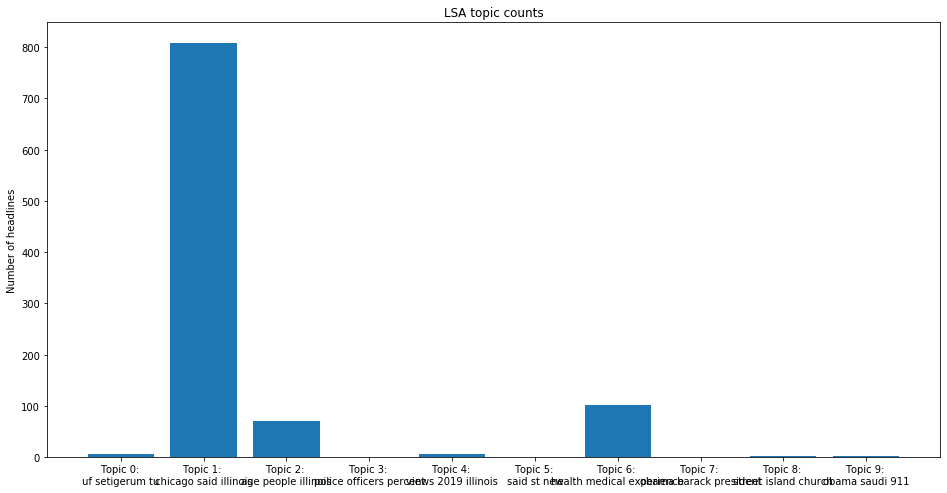

In [89]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

In [90]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.391149
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.320160
[t-SNE] KL divergence after 1850 iterations: 0.447410


In [91]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [92]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [93]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

# Sentiment analysis

In [23]:
from collections import defaultdict
news_classification = news_classification.reset_index(drop=True)

all_reviews = news_classification['text_clean']
all_sent_values = []
all_sentiments = []

In [24]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def sentiment_value(paragraph):
    analyser = SentimentIntensityAnalyzer()
    result = analyser.polarity_scores(paragraph)
    score = result['compound']
    return round(score,1)

In [25]:
for i in range(0,1110):
    all_sent_values.append(sentiment_value(all_reviews[i]))

In [26]:
SENTIMENT_VALUE = []
SENTIMENT = []
for i in range(0,1110):
    sent = all_sent_values[i]
    if (sent<=1 and sent>=0.5):
        SENTIMENT.append('V.Positive')
        SENTIMENT_VALUE.append(5)
    elif (sent<0.5 and sent>0):
        SENTIMENT.append('Positive')
        SENTIMENT_VALUE.append(4)
    elif (sent==0):
        SENTIMENT.append('Neutral')
        SENTIMENT_VALUE.append(3)
    elif (sent<0 and sent>=-0.5):
        SENTIMENT.append('Negative')
        SENTIMENT_VALUE.append(2)
    else:
        SENTIMENT.append('V.Negative')
        SENTIMENT_VALUE.append(1)
        

In [27]:
len(all_sent_values)

1110

In [28]:
temp_data = news_eng[0:1110]

In [29]:
temp_data.shape

(1110, 2)

In [30]:
temp_data['SENTIMENT_VALUE'] = SENTIMENT_VALUE
temp_data['SENTIMENT'] = SENTIMENT

In [31]:
temp_data.head(10)

text  \
2    news knowthis: trump vs. chicago & relentless fires rage cali "we've seen fires tragedies people...   
44   reprints print century 21 pride realty this new house holland harbor drive lighthouse pointe dev...   
89   why pressure property taxes growing illinois amid pension burden the cost public safety pensions...   
119  reports: underrepresented students illinois institutions impacted budget cuts october 30, 2019 |...   
197  download wirepoints’ accompanying handout: “chicago’s financial crisis” today, talk city’s 2020 ...   
204  people are leaving these major u.s. cities in droves, and we can relate to the reasons why updat...   
549  teachers chicago, home nation’s third-largest school system, reached deal city thursday set retu...   
601  from wikipedia. village avon township, lake county, illinois. 1.88 square miles, 2010 population...   
652  it’s time year ghouls goblins, mummies monsters force. but unlike many halloween creatures, bats...   
686  getty images president donald trump took swipe chicago visiting monday, saying city - longtime t...   

                                                                                              text_clean  \
2    news knowthis: trump vs. chicago  relentless fires rage cali weve seen fires tragedies people be...   
44   reprints print century 21 pride realty this new house holland harbor drive lighthouse pointe dev...   
89   why pressure property taxes growing illinois amid pension burden the cost public safety pensions...   
119  reports: underrepresented students illinois institutions impacted budget cuts october 30, 2019  ...   
197  download wirepoints accompanying handout: chicagos financial crisis today, talk citys 2020 budge...   
204  people are leaving these major u.s. cities in droves, and we can relate to the reasons why updat...   
549  teachers chicago, home nations thirdlargest school system, reached deal city thursday set return...   
601  from wikipedia. village avon township, lake county, illinois. 1.88 square miles, 2010 population...   
652  its time year ghouls goblins, mummies monsters force. but unlike many halloween creatures, bats ...   
686  getty images president donald trump took swipe chicago visiting monday, saying city  longtime ta...   

     SENTIMENT_VALUE   SENTIMENT  
2                  1  V.Negative  
44                 2    Negative  
89                 5  V.Positive  
119                1  V.Negative  
197                1  V.Negative  
204                5  V.Positive  
549                5  V.Positive  
601                5  V.Positive  
652                1  V.Negative  
686                1  V.Negative

# Classification using Sentiment Value

In [32]:

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd

In [33]:
le = preprocessing.LabelEncoder()

In [34]:
le.fit(news_classification.text_clean)

LabelEncoder()

In [35]:
targets = list(le.classes_)
print(targets)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [36]:
le.transform(news_classification['text_clean'])


array([ 602,  823, 1068, ...,  864,  887,  788])

# Train Test Split


In [37]:

X = temp_data.text_clean
y = temp_data.SENTIMENT_VALUE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# Naive Bayes Classifier


In [38]:

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [39]:

%%time

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))


accuracy 0.7117117117117117
CPU times: user 945 ms, sys: 7.02 ms, total: 952 ms
Wall time: 159 ms


In [40]:
X_test_2 = ["""News KnowThis: Trump vs. Chicago Relentless Fires Rage Cali Weve seen fires tragedies people believed could stay. Do that. The thing cannot replace family. Versha Sharma Published 10282019 11:00PM Associated Press Relentless Wildfires Rage Across California With No Sign Of Stopping There two major raging wildfires threatening Northern Southern California, prompting Gov. Gavin Newsom declare state emergency. The Getty Fire, started overnight Los Angeles, joins Kincade Fire started Sonoma County last Wednesday. Last night, Kincade Fire still burning control fifth day, dropping 10 containment 5 due hurricaneforce winds dry conditions allowed spread made difficult control. Several smaller fires also burning throughout state, extremely critical fire weather conditions remain. At around 2 a.m. Monday, fire erupted near LAs famed Getty Museum. Police told thousands people evacuate, including Arnold Schwarzenegger, LeBron James, LA Mayor Eric Garcettis parents. About 25,000 live LA evacuation zone, covers swath highpriced real estate. A fire December 2017 lit area forced drivers horrifying, apocalypticlooking morning commute . Heres latest: Officials still investigating source fires, though Pacific Gas Electric PGE told state regulators one power lines malfunctioned, may started Kincade Fire. PGE also criticized handled preemptively cutting power 1.3 million California residents. The utility company avoid possibility downed power lines, many customers complained werent given enough notice lack power lasted days incredibly disruptive, especially lowincome elderly communities . There 200,000 evacuations Sonoma County Kincade Fire, grown 66,200 acres, size Sacramento. The Kincade fire expected burn another week half, theres rain forecast sight. At least 3,400 first responders personnel fighting wildfires. Gov. Newsom tweeted link fundraiser Wildfire Relief Fund . He says far 30k raised victims recovery efforts. KnowThis: The people hit hardest natural manmade disasters already vulnerable: homeless populations, elderly, lowincome populations without access emergency prep. This LA Times dispatch describes housekeeper gardener showed midst ash fire clients homes work without realizing homeowners already evacuated. See Californians dealing firsthand Snapchat story. Getty Images U.S. Air Quality Worsens For The First Time In A Decade Speaking wildfires threat public health: A new report says air quality United States gotten worse since 2016, first time thats happened 10 years improvement. The National Bureau Economic Research published paper studying fine particulate pollution showing increased 5.5 2016 2018 U.S. decreasing almost 25 8 years prior. The studys authors say wildfires incredibly dangerous one contributing factor increase pollution. Different regions U.S. saw different rates pollution numbers stayed Northeast South, Midwest West saw significant decreases air quality. Other contributing factors, theorized studys authors, increased economic activity more factory, power plant, transportation emissions lower enforcement environmental regulation. KnowThis: The Trump administration rolled back 85 environmental regulations since 2016, including enforcement Clean Air Act. See , courtesy The New York Times. Brutal ISIS Leader Killed In U.S. Raid Abu Bakr alBaghdadi, ISIS leader said grown jihadist group international network terrorists, killed raid U.S. special forces weekend. President Donald Trump announced news Sunday. During nighttime raid northwest Syria Saturday, alBaghdadi cornered U.S. military died detonated suicide vest wearing. According President Trump, explosion also killed three alBaghdadis children. U.S. forces searching ISIS leader years, naming one wanted terrorists world. According State Department official, man known spokesperson ISIS, Abu alHassan alMuhajir, killed U.S. forces separate raid. KnowThis: The key information led U.S. forces find alBaghdadi came Kurdish informant gave American military layout terrorists compound. Earlier summer, informant handed alBaghdadis used underwear sample blood U.S. forces could confirm identity they got positive DNA match ISIS leader. Despite intel sharing, President Trump still decided withdraw U.S. forces northern Syria, leaving Kurdish allies vulnerable Turkish invasion. Getty Images President Trump Picks A Fight With The City Of Chicago Donald Trumps first visit Chicago sitting president didnt go well. After getting booed MLB World Series game Washington, D.C., last night , flew Chicago today speak International Association Chiefs Police conference, slammed local police superintendent putting criminals illegal aliens citizens Chicago. He also said Afghanistan safer comparison . The superintendent Trump singled out, Eddie Johnson, boycotted gathering later responded press conference pointed decline violent crime Chicago past years. Johnson said, Comments like made lets know I right thing moving Chicago direction going. He also said, If Trump truly ready, president known lot talking city Chicago, truly, truly ready roll sleeves partner us, we. Meanwhile, thousands protesters gathered outside Trump Tower Chicago, president hosting fundraiser. While many protesters held signs supporting impeachment, Trump called ongoing inquiry scam compared actor Jussie Smolletts case. Itaposs real big scam, like impeachment president scam, said , referring hate crime allegations made Smollett, Chicago police later said fabricated. Chicago Mayor Lori Lightfoot hold back response, tweeting, Itaposs surprise Trump brought insulting, ignorant buffoonery Chicago. Luckily, city, know truth let anyone matter high office denigrate people status welcoming city. KnowThis: Today marks 8th day Chicago Teachers Union strike . President Trump mention remarks. Lyft Will Offer Free Rides For Unemployed People To Go To Job Interviews Lyft offering free discounted rides job interviews across U.S. Canada part newly launched Jobs Access Program. Its part companys 50 million annual commitment give communities barriers transportation better access job opportunities, including people disabilities, lowincome communities, veterans. Lyft says riders quality get free discounted rides job interviews, job training, even work first three weeks job, get first paycheck. For unemployed, reliable transportation job interview first weeks work mean difference successful longterm employment lost opportunities, company said statement. Lyft yet provided launch date program. The news comes affordable transportation treated emerging priority Congress. Earlier month, Reps. Ayanna Pressley, Chuy Garca, Mark Takano launched firstever Future Transportation Caucus, dedicated creating vision future transportation system emphasizes equity, access, sustainability. As Rep. Pressley put it, Transportation literally affects everything. Its ultimately social justice issue. You hear speak exclusive congressional town hall last week watch replay . KnowThis: According company study riders, Lyft found 44 rides start end lowincome area. The company also cited study website found commuting time single strongest factor individuals effort escape poverty. Video Of The Day:"""]

In [41]:
new_pred = nb.predict(X_test_2)


In [42]:
new_pred


array([5])

# XG Boost Classifier

In [43]:
from xgboost import XGBClassifier


In [44]:

xgb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier()),
              ])
xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing

In [45]:
%%time

y_pred = xgb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.8438438438438438
CPU times: user 212 ms, sys: 3.38 ms, total: 215 ms
Wall time: 214 ms


In [46]:
new_pred1 = xgb.predict(X_test_2)


In [47]:
new_pred1

array([1])

In [48]:
import ast


# Name & Entity Recognition

In [49]:
text=temp_data['text_clean'].str.cat(sep=', ')


In [50]:
text=str(text)

In [51]:
text

'news knowthis: trump vs. chicago  relentless fires rage cali weve seen fires tragedies people believed could stay. do that. the thing cannot replace family. versha sharma published 10282019 11:00pm associated press relentless wildfires rage across california with no sign of stopping there two major raging wildfires threatening northern southern california, prompting gov. gavin newsom declare state emergency. the getty fire, started overnight los angeles, joins kincade fire started sonoma county last wednesday. last night, kincade fire still burning control fifth day, dropping 10 containment 5 due hurricaneforce winds dry conditions allowed spread made difficult control. several smaller fires also burning throughout state,  extremely critical fire weather conditions  remain. at around 2 a.m. monday, fire erupted near las famed getty museum. police told thousands people evacuate, including arnold schwarzenegger, lebron james, la mayor eric garcettis parents. about 25,000 live la evacuat

In [52]:
entities = []
labels = []

for sent in nltk.sent_tokenize(text):
    for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent)), binary = False):
        if hasattr(chunk, 'label'):
            entities.append(' '.join(c[0] for c in chunk)) #Add space as between multi-token entities
            labels.append(chunk.label())

#entities_labels = list(zip(entities, labels))
entities_labels = list(set(zip(entities, labels))) #unique entities

In [53]:
entities_df = pd.DataFrame(entities_labels)
entities_df.columns = ["Entities", "Labels"]
entities_df.head(20)

Entities        Labels
0        clinton        PERSON
1            ___  ORGANIZATION
2         calif.           GPE
3        johnson        PERSON
4            mr.        PERSON
5           u.s.        PERSON
6       johnston        PERSON
7         c.b.a.  ORGANIZATION
8         u.s.a.  ORGANIZATION
9   anatolia.and           GPE
10     u.n.do.c.  ORGANIZATION
11          u.n.  ORGANIZATION
12   mr. johnson        PERSON
13        mr. w.        PERSON
14           st.           GPE
15        c.f.a.  ORGANIZATION
16        c.i.a.  ORGANIZATION
17        m.b.a.  ORGANIZATION
18          d.c.           GPE
19          u.s.           GPE

In [54]:
entities_df.shape

(26, 2)

In [55]:
Person=entities_df[entities_df['Labels']=='PERSON']

In [56]:
Person.head(25)

Entities  Labels
0       clinton  PERSON
3       johnson  PERSON
4           mr.  PERSON
5          u.s.  PERSON
6      johnston  PERSON
12  mr. johnson  PERSON
13       mr. w.  PERSON
22    mr. hamad  PERSON
23       mr. e.  PERSON

In [57]:
Person.shape

(9, 2)

In [58]:
Org=entities_df[entities_df['Labels']=='ORGANIZATION']

In [59]:
Org.head(20)

Entities        Labels
1         ___  ORGANIZATION
7      c.b.a.  ORGANIZATION
8      u.s.a.  ORGANIZATION
10  u.n.do.c.  ORGANIZATION
11       u.n.  ORGANIZATION
15     c.f.a.  ORGANIZATION
16     c.i.a.  ORGANIZATION
17     m.b.a.  ORGANIZATION
21   c.f.s.a.  ORGANIZATION
25         __  ORGANIZATION

In [60]:
Org.shape

(10, 2)

In [61]:
Organizations=Org['Entities'].tolist()

In [62]:
import nltk
import re


# Create a regex from the list of states
Organizations_re = re.compile("|".join(Organizations)) 

results = [sent for sent in nltk.sent_tokenize(text) \
           if Organizations_re.search(sent)] # Check the condition
#['Hello, California!', 'Hello, e.g., Florida?']

In [63]:
Org_final=pd.DataFrame(results)

In [64]:
pd.set_option('display.max_colwidth', 10000)


In [65]:
Org_final.head(3)

0
0                                                  news knowthis: trump vs. chicago  relentless fires rage cali weve seen fires tragedies people believed could stay.
1  last night, kincade fire still burning control fifth day, dropping 10 containment 5 due hurricaneforce winds dry conditions allowed spread made difficult control.
2                                                           several smaller fires also burning throughout state,  extremely critical fire weather conditions  remain.

In [66]:
Org_final = Org_final.rename(columns={0: 'Entities'})

In [67]:
Org_final.shape

(8558, 1)

In [68]:
Org_final = Org_final.reset_index(drop=True)

all_reviews_Org = Org_final['Entities']
all_sent_values_Org = []
all_sentiments_Org = []

In [69]:
for i in range(0,5133):
    all_sent_values_Org.append(sentiment_value(all_reviews_Org[i]))

In [70]:
len(all_sent_values_Org)

5133

In [71]:
SENTIMENT_VALUE_Org = []
SENTIMENT_Org = []
for i in range(0,5133):
    sent_Org = all_sent_values_Org[i]
    if (sent_Org<=1 and sent_Org>=0.5):
        SENTIMENT_Org.append('V.Positive')
        SENTIMENT_VALUE_Org.append(5)
    elif (sent_Org<0.5 and sent_Org>0):
        SENTIMENT_Org.append('Positive')
        SENTIMENT_VALUE_Org.append(4)
    elif (sent_Org==0):
        SENTIMENT_Org.append('Neutral')
        SENTIMENT_VALUE_Org.append(3)
    elif (sent_Org<0 and sent_Org>=-0.5):
        SENTIMENT_Org.append('Negative')
        SENTIMENT_VALUE_Org.append(2)
    else:
        SENTIMENT_Org.append('V.Negative')
        SENTIMENT_VALUE_Org.append(1)

In [72]:
temp_data_Org = Org_final[0:5133]

In [73]:
temp_data_Org.head(5)

Entities
0                                                  news knowthis: trump vs. chicago  relentless fires rage cali weve seen fires tragedies people believed could stay.
1  last night, kincade fire still burning control fifth day, dropping 10 containment 5 due hurricaneforce winds dry conditions allowed spread made difficult control.
2                                                           several smaller fires also burning throughout state,  extremely critical fire weather conditions  remain.
3                                                                                       the kincade fire expected burn another week half, theres rain forecast sight.
4  knowthis: the people hit hardest natural manmade disasters already vulnerable: homeless populations, elderly, lowincome populations without access emergency prep.

In [74]:
temp_data_Org['SENTIMENT_VALUE'] = SENTIMENT_VALUE_Org
temp_data_Org['SENTIMENT'] = SENTIMENT_Org

In [75]:
temp_data_Org.head()

Entities  \
0                                                  news knowthis: trump vs. chicago  relentless fires rage cali weve seen fires tragedies people believed could stay.   
1  last night, kincade fire still burning control fifth day, dropping 10 containment 5 due hurricaneforce winds dry conditions allowed spread made difficult control.   
2                                                           several smaller fires also burning throughout state,  extremely critical fire weather conditions  remain.   
3                                                                                       the kincade fire expected burn another week half, theres rain forecast sight.   
4  knowthis: the people hit hardest natural manmade disasters already vulnerable: homeless populations, elderly, lowincome populations without access emergency prep.   

   SENTIMENT_VALUE   SENTIMENT  
0                1  V.Negative  
1                1  V.Negative  
2                1  V.Negative  
3                2    Negative  
4                2    Negative

In [76]:
temp_data_Org['SENTIMENT'].value_counts()

Neutral       1647
V.Positive    1103
Positive      1003
Negative       938
V.Negative     442
Name: SENTIMENT, dtype: int64

In [77]:
temp_data_Org[temp_data_Org['SENTIMENT']=='Positive'].head(5)

Entities  \
9                                                                                                                                                                                                                                 johnson said, comments like made lets know i right thing moving chicago direction going.   
15                                                                                                           the key difference chicago market national picture, doersching explained past data releases, slowly rising prices existing homes make hard builders provide bargain alternative, traditional sales advantage.   
25                                                                                                                          he officials cities say target much lower  perhaps 60 percent  considering citys ability make annual benefit payments still financial cushion anticipation investment losses market downturns.   
26  this story produced better government association, nonprofit news organization based chicago., reports: underrepresented students illinois institutions impacted budget cuts october 30, 2019  : print a recent period higher education cutbacks illinois created affordability equity gaps underrepresented students.   
37                                                                                                            but try things right, mayor lightfoot would change course put together workout team  restructuring group  determines reduce chicagos debts city become competitive taxation, services, economic environment.   

    SENTIMENT_VALUE SENTIMENT  
9                 4  Positive  
15                4  Positive  
25                4  Positive  
26                4  Positive  
37                4  Positive

In [78]:
temp_data_Org[temp_data_Org['SENTIMENT']=='V.Positive'].head(5)

Entities  \
10                                                                                                           he also said, if trump truly ready, president known lot talking city chicago, truly, truly ready roll sleeves partner us, we.   
17  in illinois 28 largest cities beyond chicago  populations 50,000  rate pension payment increases outstripped growth property tax revenue factor 10 since 2012, better government association review financial pension documents shows.   
18                                                                            j.b. pritzker earlier month proposed partial solution: consolidate investment operations funds, intent saving money improving financial returns investments.   
19                   you need structural reform pensions look like going forward theres chance municipalities survive end like state illinois, dropping 20 30 percent funding level, said reid ottesen, longtime village manager palatine.   
23                                                                                                                                    i would feel like jerk i able provide retirement put blood, sweat, tears love city, cunningham said.   

    SENTIMENT_VALUE   SENTIMENT  
10                5  V.Positive  
17                5  V.Positive  
18                5  V.Positive  
19                5  V.Positive  
23                5  V.Positive

In [79]:
temp_data_Org[temp_data_Org['SENTIMENT']=='Negative'].head(10)

Entities  \
3                                                                                                       the kincade fire expected burn another week half, theres rain forecast sight.   
4                  knowthis: the people hit hardest natural manmade disasters already vulnerable: homeless populations, elderly, lowincome populations without access emergency prep.   
5                                       despite intel sharing, president trump still decided withdraw u.s. forces northern syria, leaving kurdish allies vulnerable turkish invasion.   
6                                              getty images president trump picks a fight with the city of chicago donald trumps first visit chicago sitting president didnt go well.   
11                                                                                meanwhile, thousands protesters gathered outside trump tower chicago, president hosting fundraiser.   
13                                                  chicago mayor lori lightfoot hold back response, tweeting, itaposs surprise trump brought insulting, ignorant buffoonery chicago.   
14                                                                                                                      knowthis: today marks 8th day chicago teachers union strike .   
16                                                               much focus pension problem illinois massive liabilities facing five statewide funds well chicagos citywide pensions.   
21  whats more, obstacles rooted demographic economic disparities define illinois, state nine 10 counties losing population job growth increasingly gravitating metropolitan chicago.   
22                                                                                              so, city paid operating costs bonds, said mayor sam cunningham, aware longterm risks.   

    SENTIMENT_VALUE SENTIMENT  
3                 2  Negative  
4                 2  Negative  
5                 2  Negative  
6                 2  Negative  
11                2  Negative  
13                2  Negative  
14                2  Negative  
16                2  Negative  
21                2  Negative  
22                2  Negative

In [80]:
temp_data_Org[temp_data_Org['SENTIMENT']=='V.Negative'].head(10)

Entities  \
0                                                                                                                                                                           news knowthis: trump vs. chicago  relentless fires rage cali weve seen fires tragedies people believed could stay.   
1                                                                                                                           last night, kincade fire still burning control fifth day, dropping 10 containment 5 due hurricaneforce winds dry conditions allowed spread made difficult control.   
2                                                                                                                                                                                    several smaller fires also burning throughout state,  extremely critical fire weather conditions  remain.   
7                                                 after getting booed mlb world series game washington, d.c., last night , flew chicago today speak international association chiefs police conference, slammed local police superintendent putting criminals illegal aliens citizens chicago.   
8                                                                                                                                 the superintendent trump singled out, eddie johnson, boycotted gathering  later responded press conference pointed decline violent crime chicago past years.   
12                                                                                                                                        itaposs real big scam, like impeachment president scam, said , referring hate crime allegations made smollett, chicago police later said fabricated.   
20  amanda kass university illinois chicago, years monitoring performance police firefighter pensions, notes state serious problems 130 billion unfunded liabilities average funding level 40 percent, one lowest among states, local governments fewer tools maintain public safety pensions.   
27                                                                                                                              sarah wood reached ., download wirepoints accompanying handout: chicagos financial crisis today, talk citys 2020 budget, id argue thats wrong way look crisis.   
28                                                                                                                                                                                                                                               chicagos problems far larger oneyear deficit.   
30                                                                                                                                                                                                                                    chicago households burdened far debt major city country.   

    SENTIMENT_VALUE   SENTIMENT  
0                 1  V.Negative  
1                 1  V.Negative  
2                 1  V.Negative  
7                 1  V.Negative  
8                 1  V.Negative  
12                1  V.Negative  
20                1  V.Negative  
27                1  V.Negative  
28                1  V.Negative  
30                1  V.Negative

In [81]:
Person_list=Person['Entities'].tolist()

In [82]:
Person_re = re.compile("|".join(Person_list)) 

results1 = [sent for sent in nltk.sent_tokenize(text) \
           if Person_re.search(sent)] # Check the condition


In [83]:
Person_final=pd.DataFrame(results1)

In [84]:
Person_final.head(3)

0
0  getty images u.s. air quality worsens for the first time in a decade speaking wildfires threat public health: a new report says air quality united states gotten worse since 2016, first time thats happened 10 years improvement.
1                                                                  the national bureau economic research published paper studying fine particulate pollution showing increased 5.5 2016 2018 u.s. decreasing almost 25 8 years prior.
2                                                                                           different regions u.s. saw different rates pollution  numbers stayed northeast south, midwest west saw significant decreases air quality.

In [85]:
Person_final = Person_final.rename(columns={0: 'Entities'})

In [86]:
Person_final.shape

(6802, 1)

In [109]:
Person_final.head(5)

Entities
0  getty images u.s. air quality worsens for the first time in a decade speaking wildfires threat public health: a new report says air quality united states gotten worse since 2016, first time thats happened 10 years improvement.
1                                                                  the national bureau economic research published paper studying fine particulate pollution showing increased 5.5 2016 2018 u.s. decreasing almost 25 8 years prior.
2                                                                                           different regions u.s. saw different rates pollution  numbers stayed northeast south, midwest west saw significant decreases air quality.
3                                                        brutal isis leader killed in u.s. raid abu bakr albaghdadi, isis leader said grown jihadist group international network terrorists, killed raid u.s. special forces weekend.
4                                                                                                              during nighttime raid northwest syria saturday, albaghdadi cornered u.s. military died detonated suicide vest wearing.

In [87]:
Person_final = Person_final.reset_index(drop=True)

all_reviews_Person = Person_final['Entities']
all_sent_values_Person = []
all_sentiments_Person = []

In [103]:
for i in range(0,6802):
    all_sent_values_Person.append(sentiment_value(all_reviews_Person[i]))

In [104]:
len(all_sent_values_Person)

20406

In [110]:
SENTIMENT_VALUE_Person = []
SENTIMENT_Person = []
for i in range(0,6802):
    sent_person = all_sent_values_Person[i]
    if (sent_person<=1 and sent_person>=0.5):
        SENTIMENT_Person.append('V.Positive')
        SENTIMENT_VALUE_Person.append(5)
    elif (sent_person<0.5 and sent_person>0):
        SENTIMENT_Person.append('Positive')
        SENTIMENT_VALUE_Person.append(4)
    elif (sent_person==0):
        SENTIMENT_Person.append('Neutral')
        SENTIMENT_VALUE_Person.append(3)
    elif (sent_person<0 and sent_person>=-0.5):
        SENTIMENT_Person.append('Negative')
        SENTIMENT_VALUE_Person.append(2)
    else:
        SENTIMENT_Person.append('V.Negative')
        SENTIMENT_VALUE_Person.append(1)

In [111]:
temp_data_Person = Person_final[0:6802]

In [112]:
temp_data_Person.head(5)

Entities
0  getty images u.s. air quality worsens for the first time in a decade speaking wildfires threat public health: a new report says air quality united states gotten worse since 2016, first time thats happened 10 years improvement.
1                                                                  the national bureau economic research published paper studying fine particulate pollution showing increased 5.5 2016 2018 u.s. decreasing almost 25 8 years prior.
2                                                                                           different regions u.s. saw different rates pollution  numbers stayed northeast south, midwest west saw significant decreases air quality.
3                                                        brutal isis leader killed in u.s. raid abu bakr albaghdadi, isis leader said grown jihadist group international network terrorists, killed raid u.s. special forces weekend.
4                                                                                                              during nighttime raid northwest syria saturday, albaghdadi cornered u.s. military died detonated suicide vest wearing.

In [113]:
temp_data_Person['SENTIMENT_VALUE'] = SENTIMENT_VALUE_Person
temp_data_Person['SENTIMENT'] = SENTIMENT_Person

In [114]:
pd.set_option('display.max_colwidth', 10000)


In [115]:
temp_data_Person.head()

Entities  \
0  getty images u.s. air quality worsens for the first time in a decade speaking wildfires threat public health: a new report says air quality united states gotten worse since 2016, first time thats happened 10 years improvement.   
1                                                                  the national bureau economic research published paper studying fine particulate pollution showing increased 5.5 2016 2018 u.s. decreasing almost 25 8 years prior.   
2                                                                                           different regions u.s. saw different rates pollution  numbers stayed northeast south, midwest west saw significant decreases air quality.   
3                                                        brutal isis leader killed in u.s. raid abu bakr albaghdadi, isis leader said grown jihadist group international network terrorists, killed raid u.s. special forces weekend.   
4                                                                                                              during nighttime raid northwest syria saturday, albaghdadi cornered u.s. military died detonated suicide vest wearing.   

   SENTIMENT_VALUE   SENTIMENT  
0                1  V.Negative  
1                4    Positive  
2                4    Positive  
3                1  V.Negative  
4                1  V.Negative

In [116]:
temp_data_Person['SENTIMENT'].value_counts()

Neutral       1721
V.Positive    1621
Positive      1426
Negative      1317
V.Negative     717
Name: SENTIMENT, dtype: int64

In [117]:
temp_data_Person[temp_data_Person['SENTIMENT']=='Positive'].head(15)

Entities  \
1                                                                                                                                                       the national bureau economic research published paper studying fine particulate pollution showing increased 5.5 2016 2018 u.s. decreasing almost 25 8 years prior.   
2                                                                                                                                                                                different regions u.s. saw different rates pollution  numbers stayed northeast south, midwest west saw significant decreases air quality.   
11                                                                                                                                                                                                                                johnson said, comments like made lets know i right thing moving chicago direction going.   
26  this story produced better government association, nonprofit news organization based chicago., reports: underrepresented students illinois institutions impacted budget cuts october 30, 2019  : print a recent period higher education cutbacks illinois created affordability equity gaps underrepresented students.   
29                                                                                                            but try things right, mayor lightfoot would change course put together workout team  restructuring group  determines reduce chicagos debts city become competitive taxation, services, economic environment.   
32                                                                                                                                  whoakimosabe  instagram reportedly, complaints amid chicago residents span issues like citys high cost living with median home value 229,00, education system, amenities property tax.   
40                                                                                                                                                          its also available https:t.cotx374tgvxx pic.twitter.comcmgq7htx8v  chicagopublicschools @chipubschools october 29, 2019 the strike gained highprofile backers.   
41                                                                                                                                                                                                                                   high school seniors applying college could get help teachers counselors applications.   
48                                                                                                                                                                                                                   in addition pest control, bats  40 different species live u.s.  help pollinate plants disperse seeds.   
49                                                                                                                                                                                                                         and contrary popular myth, less half 1 bats carry rabies, according u.s. fish wildlife service.   
51                                                                                                                                                                 in nutshell, bat species n. america well, andrew king, fish wildlife biologist wildlife services indiana field office bloomington, indiana, said email.   
55                                                                                                                                                                                                                     the u.s. department interior says changes regulations designed increase transparency effectiveness.   
69                                                                                                                                                                          

In [118]:
temp_data_Person[temp_data_Person['SENTIMENT']=='V.Positive'].head(15)

Entities  \
8                                                                                                                    earlier summer, informant handed albaghdadis used underwear sample blood u.s. forces could confirm identity they got positive dna match isis leader.   
14                                                                                lyft will offer free rides for unemployed people to go to job interviews lyft offering free discounted rides job interviews across u.s. canada part newly launched jobs access program.   
19                                 in illinois 28 largest cities beyond chicago  populations 50,000  rate pension payment increases outstripped growth property tax revenue factor 10 since 2012, better government association review financial pension documents shows.   
27                                                            kyle westbrook in general, order address equity issues, institutions need focus remedial courses developmental education ensure illinois giving students best possible chance succeed, according westbrook.   
28                                                                                                                                                                          and property values, real terms, worth less today 2000. chicagos growth drags far big cities.   
30  and nobody wants that., people are leaving these major u.s. cities in droves, and we can relate to the reasons why updated 1 day ago october 29, 2019 impact  michael roque 11. rockford, illinois  18,789 migrations rockford, illinois definitely seen better days.   
31                                                                                                                                                                                                                 were guessing warmer weather plays huge part decision.   
35                                                                                                                                         in interest students parents suffering, important make sure got kids class, said lightfoot city hall news conference thursday.   
42                                                        chicagoteachersstrike https:t.couiwwnnqtzx pic.twitter.comtuj2e7oyeh  linda lutton @lindalutton october 29, 2019 carmen guzman, teaches first grade louis pasteur elementary, said pleased gains teachers made.   
45                                                                                                                                                                   aside rare nuisance appearances attics, bats play positive, critical role ecosystem, scientists say.   
47                                                                                 bats benefit humans summer eating pesky insects, including mosquitoes, provide important protection midwestern crops like corn soybeans feasting bugs could otherwise ravage farmland.   
54                                                                                                            those new rules may make harder little brown bat northern longeared bat earn protections, even work continues bolster fascinating creatures chances thrive.   
57                                                          i hope u.s. fish wildlife service consider economic ramifications listing species, said joy okeefe, associate professor biology director center bat research, outreach conservation indiana state university.   
66                                                                                                                                                                   aside rare nuisance appearances attics, bats play positive, critical role ecosystem, scientists say.   
68                                                                                 bats benefit humans summer eating pesky insects, including mosquitoes, provide important protection midwestern crops like corn soybeans fea

In [119]:
temp_data_Person[temp_data_Person['SENTIMENT']=='Negative'].head(15)

Entities  \
9                                                                                                                                                                                                                despite intel sharing, president trump still decided withdraw u.s. forces northern syria, leaving kurdish allies vulnerable turkish invasion.   
12                                                                                                                                                                                                                                                         meanwhile, thousands protesters gathered outside trump tower chicago, president hosting fundraiser.   
13                                                                                                                                                                                                                            while many protesters held signs supporting impeachment, trump called ongoing inquiry scam compared actor jussie smolletts case.   
17                                                                                                                                                                                         both well dismal thirdquarter 2017 sales total: 750. tracy crosss data captures homes sold developments 10 covers detached houses attached condominiums townhouses.   
21                                                                                                                                                                                                                                                                                          which means service cuts, addressing service infrastructure needs.   
25                                                                                                                                           back springfield, mccarty, served budget positions administrations governors george ryan rod blagojevich, argues statemandated target pensions reach funding level 90 percent 2045 added unnecessary cost system.   
33                                                                                above from: https:www.icepop.comuscitiesmigratingpopulations15, teachers chicago, home nations thirdlargest school system, reached deal city thursday set return 300,000 students 25,000 teachers classrooms friday, marking end one longest teacher strikes recent history.   
34  and comes amid resurgence teacher activism urban school systems following wave walkouts conservative states 2018. the strike, kept students classrooms 11 days, brought tens thousands people chicagos streets picket lines teachers pressed city hire teachers, social workers school nurses city threequarters schoolchildren come lowincome households.   
36                                                                                                                                                                                                                     it also calls hiring nurses social workers one assigned school 2023. teachers also set get 16 percent pay raise life fiveyear contract.   
37                                                                                                                                                                         in chicago, 25,000 teachers strike 300,000 children classroom the announcement settlement made signwaving teachers rallied outside city hall blowing snow, bundled ponchos jackets.   
38                                                                                                                                                                                                 the chicago job action follows nearly two years strikes walkouts coasttocoast, including west virginia, oklahoma arizona, teachers little bargaining power.   
39                                                                                            

In [120]:
temp_data_Person[temp_data_Person['SENTIMENT']=='V.Negative'].head(15)

Entities  \
0                                                                                                                                                                                                                                                                          getty images u.s. air quality worsens for the first time in a decade speaking wildfires threat public health: a new report says air quality united states gotten worse since 2016, first time thats happened 10 years improvement.   
3                                                                                                                                                                                                                                                                                                                                brutal isis leader killed in u.s. raid abu bakr albaghdadi, isis leader said grown jihadist group international network terrorists, killed raid u.s. special forces weekend.   
4                                                                                                                                                                                                                                                                                                                                                                                      during nighttime raid northwest syria saturday, albaghdadi cornered u.s. military died detonated suicide vest wearing.   
5                                                                                                                                                                                                                                                                                                                                                                                                                                u.s. forces searching isis leader years, naming one wanted terrorists world.   
6                                                                                                                                                                                                                                                                                                                                                                                 according state department official, man known spokesperson isis, abu alhassan almuhajir, killed u.s. forces separate raid.   
7                                                                                                                                                                                                                                                                                                                                                                     knowthis: the key information led u.s. forces find albaghdadi came kurdish informant gave american military layout terrorists compound.   
10                                                                                                                                                                                                                                                                                                                                               the superintendent trump singled out, eddie johnson, boycotted gathering  later responded press conference pointed decline violent crime chicago past years.   
22                                                                                                                                                                                                                                                                                                                                                                              in past five years, mayor jim ardis said, city workforce cut 18 percent, 650. the majority cuts came ranks police fire, said.   
52          

In [ ]:
import datetime
datetime.datetime.now().strftime("%a, %d %B %Y %H:%M:%S")